# Aigerim Gilmanova 

#### Sensors and Sensing 
#### Home  Work 3
#### 6 December, 2021

# Task 1 (ID 08)

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# reading data 
im_r = cv2.imread('R000008.png', 0)
im_l = cv2.imread('L000008.png', 0)

In [3]:
# find the keypoints and descriptors with SIFT
sift = cv2.SIFT_create() 
r_kp, r_des = sift.detectAndCompute(im_r, None)
l_kp, l_des = sift.detectAndCompute(im_l, None) 

In [4]:
# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

In [5]:
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(r_des, l_des, k=2)

In [7]:
good = []
r_points = []
l_points = []

for i, (m, n) in enumerate(matches):
    if m.distance < 0.80*n.distance:
        good.append(m)
        r_points.append(r_kp[m.queryIdx].pt)
        l_points.append(l_kp[m.trainIdx].pt)
        
# find the fundamental matrix
r_points = np.int32(r_points)
l_points = np.int32(l_points)
F, mask = cv2.findFundamentalMat(r_points, l_points, cv2.FM_8POINT)
print("Fundamental matrix is:\n", F)

Fundamental matrix is:
 [[ 4.30411403e-06 -7.64735922e-04  1.34047007e-01]
 [ 7.76199566e-04  1.57491958e-04 -8.56734061e-01]
 [-1.40585883e-01  8.21890924e-01  1.00000000e+00]]


In [8]:
# removing outliers
r_points = r_points[mask.ravel()==1]
l_points = l_points[mask.ravel()==1]

# on the right image the epilines are painted for the points of left image lines
def drawlines(im_r,im_l,lines,r_points,l_points):
    r,c = im_r.shape
    im_r = cv2.cvtColor(im_r,cv2.COLOR_GRAY2BGR)
    im_l = cv2.cvtColor(im_l,cv2.COLOR_GRAY2BGR)
    for r, pt_r, pt_l in zip(lines, r_points, l_points):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        im_r = cv2.line(im_r, (x0,y0), (x1,y1), color,1)
        im_r = cv2.circle(im_r,tuple(pt_r),5,color,-1)
        im_l = cv2.circle(im_l,tuple(pt_l),5,color,-1)
    return im_r, im_l

In [9]:
# find epilines that corresponde to points of left image 
# paint its lines on the right image
lines1 = cv2.computeCorrespondEpilines(l_points.reshape(-1,1,2), 2, F)
lines1 = lines1.reshape(-1,3)
img1, img2 = drawlines(im_r, im_l,lines1, r_points, l_points)

In [10]:
# find epilines that corresponde to points of right image 
# paint its lines on the left image
lines2 = cv2.computeCorrespondEpilines(r_points.reshape(-1,1,2), 1, F)
lines2 = lines2.reshape(-1,3)
img3, img4 = drawlines(im_l,im_r,lines2,l_points,r_points)

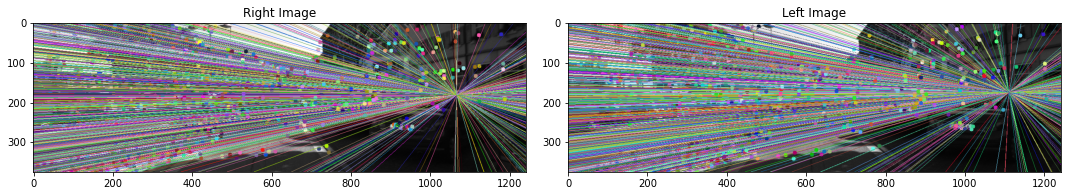

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
f.tight_layout()
ax1.imshow(img1)
ax1.set_title('Right Image')
ax2.imshow(img3)
ax2.set_title('Left Image')
plt.show()

In [12]:
im_r = cv2.imread('R000008.png', 0)
im_l = cv2.imread('L000008.png', 0)
# estimation the disparity map of the paired images
stereo = cv2.StereoBM_create(32, 7)
disparity = stereo.compute(im_r, im_l)

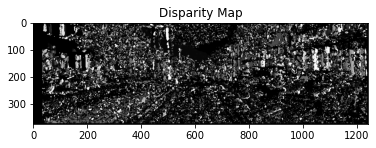

In [13]:
plt.imshow(disparity, 'gray')
plt.title('Disparity Map')
plt.show()

# Task 2

In [14]:
import imutils 

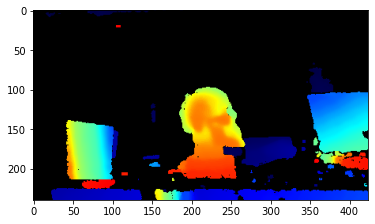

In [15]:
# reading and plotting data
# there is an depth image because the original one is white as the table, 
# where object is placed, so it impossible to extract necessary object
img = cv2.imread('last_Depth.png')
plt.imshow(img)
plt.show()

In [16]:
# making segmentation by using gray scaling, blurring it 
# and using treshold to extract the object
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
blurred = cv2.GaussianBlur(gray, (5, 5), 0) 
thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]

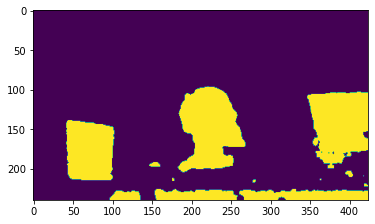

In [17]:
# plotting threshed image
plt.imshow(thresh) 

In [18]:
# finding contour 
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, 
                        cv2.CHAIN_APPROX_SIMPLE) 
cnts = imutils.grab_contours(cnts) 
for c in cnts:
   # calculate moments for each contour
    M = cv2.moments(c)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
         cX, cY = 0, 0
# drawing contour and center
    cv2.drawContours(img, [c], -1, (0, 255, 0), 2) 
    cv2.circle(img, (cX, cY), 7, (255, 255, 255), -1) 

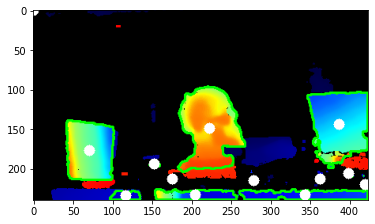

In [19]:
# segmented image in 2D
plt.imshow(img)

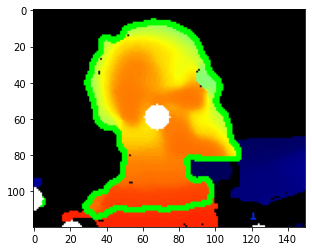

In [20]:
# cropping the image to get the necessary object
y=90
x=155
h=120
w=150
crop = img[y:y+h, x:x+w]
plt.imshow(crop)

There is a center of object in 2D. To find it in 3D, it is necessary to use .raw file. However, when I was procced with this file, it shows only a vector of one pixel. Also, after converting it into .tiff file, it shows the following result. 

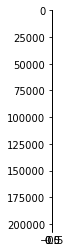

In [47]:
import matplotlib.image as mpimg
img = mpimg.imread('out.tiff')
imgplot = plt.imshow(img)
plt.show()

# Task 3

In [21]:
import pandas as pd
import utm

In [22]:
# reading data
gps_data = pd.read_csv('gps.csv')
acc_data = pd.read_csv('accelerometer.csv')

In [23]:
# getting latitude and longtitude values
lat = gps_data['latitude'].values
lon = gps_data['longitude'].values

In [24]:
# converting latitude and longtitude values into real coordinates
gps_x, gps_y, lon_zone, lat_zone = utm.from_latlon(lat, lon)

ddx = acc_data['x'].values
ddy = acc_data['y'].values

# converting from string to float
gps_data['timestamp'] = pd.to_datetime(gps_data['timestamp'])
gps_time = gps_data['timestamp'].values.astype(float).astype(int)
acc_time = acc_data['time'].values

In [25]:
# plotting function
def plot_xy(x,y, xlabel, ylabel, legend):
    fig = plt.figure(figsize=(4,4))
    
    plt.scatter(x,y, s=5, label='State', c='grey')
    plt.scatter(x[0],y[0], s=30, label='Start', c='g')
    plt.scatter(x[-1],y[-1], s=30, label='Goal', c='r')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(legend)
    plt.legend(loc='best')
    plt.axis()

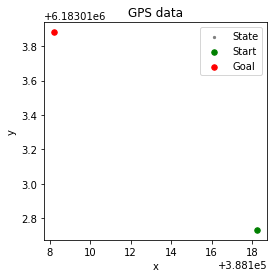

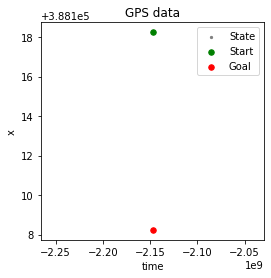

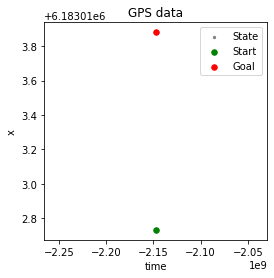

In [26]:
plot_xy(gps_x, gps_y, 'x', 'y', 'GPS data')
plot_xy(gps_time, gps_x, 'time', 'x', 'GPS data')
plot_xy(gps_time, gps_y, 'time', 'x', 'GPS data')

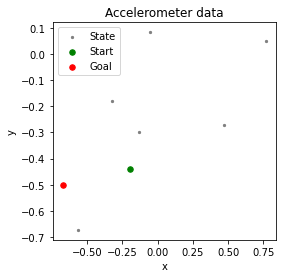

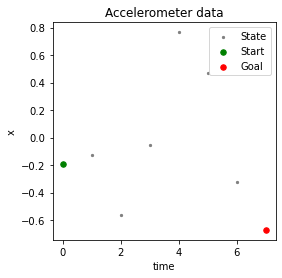

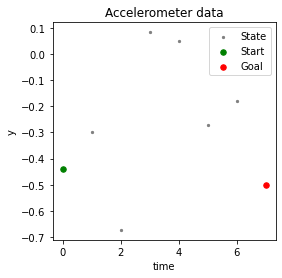

In [27]:
plot_xy(ddx, ddy, 'x', 'y', 'Accelerometer data')
plot_xy(acc_time, ddx, 'time', 'x', 'Accelerometer data')
plot_xy(acc_time, ddy, 'time', 'y', 'Accelerometer data')

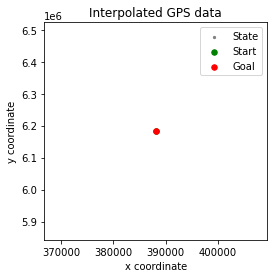

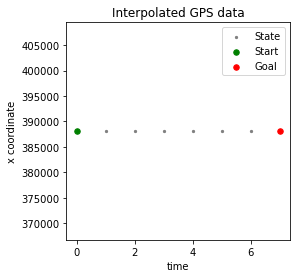

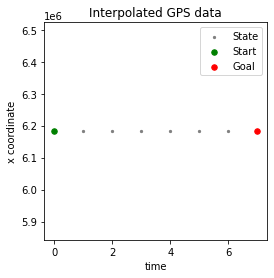

In [28]:
time = acc_time
# as the data from the sensors with different shapes, 
# it is needed to interpolate the GPS data 
# to get the same shape as accelerometer data

x = np.interp(time, gps_time, gps_x)
y = np.interp(time, gps_time, gps_y)

plot_xy(x, y, 'x coordinate', 'y coordinate', 'Interpolated GPS data')
plot_xy(time, x, 'time', 'x coordinate', 'Interpolated GPS data')
plot_xy(time, y, 'time', 'x coordinate', 'Interpolated GPS data')

In [29]:
# std and mean of data
std_x = x.std()
mean_x = x.mean()
std_y = y.std()
mean_y = y.mean()
std_ddx = ddx.std()
mean_ddx = ddx.mean()
std_ddy = ddy.std()
mean_ddy = ddy.mean()

In [30]:
# error in gps (assumptions)
std_x = 25
std_y = 25

# error in accelerator (assumptions)
std_ddx = 7
std_ddy = 7

In [31]:
# covariance matrix R of results noise
def matrix_R(std_x, std_y):
    R = np.array([[std_x**2, 0],
                  [0, std_y**2]], dtype=float)
    R = R.reshape(2, 2)
    return R

In [32]:
# covariance matrix Q of process noise 
def matrix_Q(std_ddx, std_ddy, dt):
    sigma_x = std_ddx*(dt**2)/2
    sigma_y = std_ddy*(dt**2)/2
    sigma_dx = std_ddx*dt
    sigma_dy = std_ddy*dt
    Q = np.array([[sigma_x**2, 0, sigma_x*sigma_dx, 0],
                  [0, sigma_y**2, 0, sigma_y*sigma_dy],
                  [sigma_x*sigma_dx, 0, sigma_dx**2, 0],
                  [0, sigma_y*sigma_dy, 0, sigma_dy**2]], dtype=float)
    Q = Q.reshape(4, 4)
    return Q


In [33]:
# state vector X [x, y, dx, dy]
def vector_X(x, y, dx, dy):
    X = np.array([[x],
                  [y],
                  [dx],
                  [dy]], dtype=float)
    X = X.reshape(4, 1)
    return X

In [34]:
# dynamics matrix A
def matrix_A(dt):
    A = np.array([[1, 0, dt, 0],
                  [0, 1, 0, dt],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]], dtype=float)
    A = A.reshape(4, 4)
    return A

In [35]:
# control matrix
def matrix_B(dt):
    B = np.array([[(dt**2)/2, 0],
                  [0, (dt**2)/2],
                  [dt, 0],
                  [0, dt]], dtype=float)
    B = B.reshape(4, 2)
    return B

In [36]:
# control input u
def vector_u(ddx, ddy, dt):
    u = np.array([[ddx],
                  [ddy]], dtype=float)
    u = u.reshape(2, 1)
    return u

In [37]:
# observation matrix
def matrix_C():
    C = np.array([[1, 0],
                  [0, 1]], dtype=float)
    C = C.reshape(2, 2)
    return C

In [38]:
# measuring matrix
def matrix_H():
    H = np.array([[1, 0, 0, 0],
                  [0, 1, 0, 0]], dtype=float)
    H = H.reshape(2, 4)
    return H

In [39]:
# matrix of noise measurements
def vector_Z(std_x, std_y):
    Z = np.array([[np.random.normal(loc = 0, scale = std_x)],
                  [np.random.normal(loc = 0, scale = std_y)]], dtype=float)
    Z = Z.reshape(2, 1)
    return Z

In [40]:
# matrix of process noise
def vector_W(std_ddx, std_ddy, dt):
    sigma_x = std_ddx*(dt**2)/2
    sigma_y = std_ddy*(dt**2)/2
    sigma_dx = std_ddx*dt
    sigma_dy = std_ddy*dt
    W = np.array([[np.random.normal(loc = 0, scale = sigma_x)],
                  [np.random.normal(loc = 0, scale = sigma_y)],
                  [np.random.normal(loc = 0, scale = sigma_dx)],
                  [np.random.normal(loc = 0, scale = sigma_dy)]], dtype=float)
    W = W.reshape(4, 1)
    return W

In [41]:
# covariance matrix P
def vector_P():
    P = np.array([[0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0]], dtype=float)
    P = P.reshape(4, 4)
    return P

n = time.shape[0] - 1
u = np.zeros((2,n), dtype=float)

In [42]:
time = time/1000
dt = []

for i in range(n):
    dt.append(time[i+1] - time[i])
    u_i = vector_u(ddx[i], ddy[i], dt[i])
    u[:, i] = u_i[:, 0]
    
dt = np.array(dt)

Ym = np.array([x[0:-1], y[0:-1]])

C = matrix_C()
R = matrix_R(std_x, std_y)
H = matrix_H()

X_0 = vector_X(x[0], y[0], 0, 0)
X = np.zeros((4,n), dtype=float)
X[:, 0] = X_0[:, 0]

In [43]:
def Kalman_algorithm():
    Kalman_list = []
    P = vector_P()
    for i in range(n-1):
        A = matrix_A(dt[i])
        B = matrix_B(dt[i])
        Q = matrix_Q(std_ddx, std_ddy, dt[i])
        Z = vector_Z(std_x, std_y)
        W = vector_W(std_ddx, std_ddy, dt[i])
        # calculation of the state prediction
        X_pred = np.matmul(A, X[:, i]) + np.matmul(B, u[:, i]) #+ W[:, 0]
        # calculation of covariance matrix
        P = np.matmul(A, np.matmul(P, A.transpose())) + Q

        # computing Kalman gain
        K = np.matmul(np.matmul(P, H.transpose()), np.linalg.pinv(np.matmul(H, np.matmul(P, H.transpose())) + R))
        # computing its measurements
        Y = np.matmul(C, Ym[:, i]).reshape(-1,1) #+ Z
        # updating state calculations
        x = X_pred.reshape(-1, 1) + np.matmul(K, Y - np.matmul(H, X_pred).reshape(-1,1))
        X[:, i+1] = x.reshape(-1,)
        # update its covariance matrix
        P = np.matmul((np.eye(4, k=0) - np.matmul(K, H)), P)
        Kalman_list.append(K)
        Kalman_gains = np.array(Kalman_list)
    return X, Kalman_gains

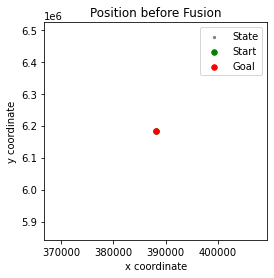

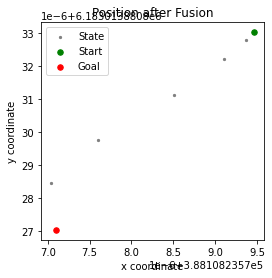

In [45]:
X, Kalman_gains = Kalman_algorithm()

plot_xy(x,y, 'x coordinate', 'y coordinate', 'Position before Fusion')
plot_xy(X[0], X[1], 'x coordinate', 'y coordinate', 'Position after Fusion')